#### Module import & Load Data

In [13]:
# 메모리내 변수 제거

all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [14]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import wordcloud
import nltk
# import seaborn as sns
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [15]:
train1 = pd.read_csv('c:/data/project/train.csv')
test = pd.read_csv('c:/data/project/test.csv')

In [16]:
train_nlp = train1.copy()
train_nlp.info()
train_nlp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [17]:
train_nlp['facts'] = train_nlp['first_party']+', '+train_nlp['second_party']+', '+train_nlp['facts']
train_nlp = train_nlp[['facts','first_party_winner']]
train_nlp

,facts,first_party_winner
0,"Phil A. St. Amant, Herman A. Thompson, On June...",1
1,"Stephen Duncan, Lawrence Owens, Ramon Nelson w...",0
2,"Billy Joe Magwood, Tony Patterson, Warden, et ...",1
3,"Linkletter, Walker, Victor Linkletter was conv...",0
4,"William Earl Fikes, Alabama, On April 24, 1953...",1
...,...,...
2473,"HollyFrontier Cheyenne Refining, LLC, et al., ...",1
2474,"Grupo Mexicano de Desarrollo, S. A., Alliance ...",1
2475,"Peguero, United States, In 1992, the District ...",0
2476,"Immigration and Naturalization Service, St. Cy...",0


In [18]:
train_target = pd.DataFrame(train_nlp, columns=['first_party_winner'])
# train_target

### 불용어 사전 정의 (사용자 지정 & 기본 제공[english])

In [19]:
##### 불용어 처리 및 어간과 표제어 추출 함수 #####

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)

    # text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'[^\w\s]', '', str(text).strip())

    # 정규식, 치환 문자열, src 문자열 입력 -> 해당 문자가 발견되지 않는 경우 space bar로 변환, 단어별 split을 위한 작업
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [20]:
##### 단어와 빈도수 측정 및 시각화 함수 #####

def word_freq(data, columns, titleName=None, graph=False):
    corpus = data[columns]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

    dic_word_freq = nltk.FreqDist(lst_tokens)
    words_freq = pd.DataFrame(dic_word_freq.most_common(), columns=["Word","Freq"])

    if graph==True:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.suptitle('Most frequent words'+titleName, fontsize=15)
        figure(figsize=(30, 24))
        
        words_freq.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(
                  kind="barh", title="words", ax=ax, 
                  legend=False).grid(axis='x')
               
        ax.set(ylabel=None)
        plt.show()
    
    return [words_freq, dic_word_freq]

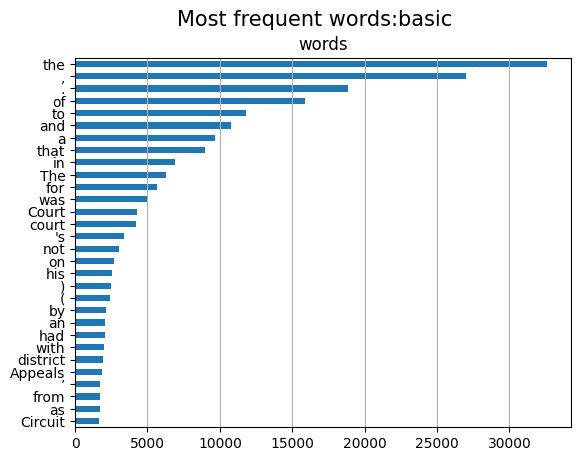

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,the,32628
1,",",27030
2,.,18818
3,of,15867
4,to,11805
...,...,...
22340,patentee,1
22341,localize,1
22342,spurious,1
22343,bar-coded,1


In [21]:
word_freq(train_nlp, 'facts', ':basic', True)[0]

##### 기본 불용어 처리

In [22]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# NLTK가 정의한 영어 불용어 리스트를 리턴

train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
# nltk 기본 불용어를 제거한 결과
train_nlp

,facts,first_party_winner
0,Phil A St Amant Herman A Thompson On June 27 1...,1
1,Stephen Duncan Lawrence Owens Ramon Nelson rid...,0
2,Billy Joe Magwood Tony Patterson Warden et al ...,1
3,Linkletter Walker Victor Linkletter convicted ...,0
4,William Earl Fikes Alabama On April 24 1953 Se...,1
...,...,...
2473,HollyFrontier Cheyenne Refining LLC et al Rene...,1
2474,Grupo Mexicano de Desarrollo S A Alliance Bond...,1
2475,Peguero United States In 1992 District Court s...,0
2476,Immigration Naturalization Service St Cyr On M...,0


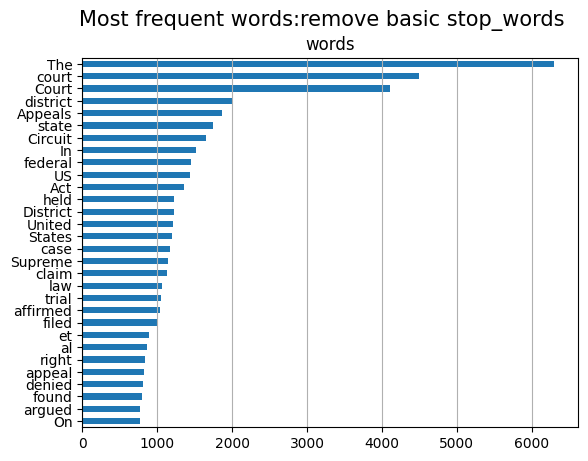

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,The,6302
1,court,4497
2,Court,4109
3,district,1994
4,Appeals,1869
...,...,...
21656,patentee,1
21657,localize,1
21658,spurious,1
21659,barcoded,1


In [23]:
word_freq(train_nlp, 'facts', ':remove basic stop_words',True)[0]

#### 승소, 패소 시의 단어 빈도수 확인

###### 위의 전처리 과정에서 얻은 facts와 first_party_winner만 남긴 데이터 프레임을 train_nlp2로 지정함

In [24]:
# train_nlp = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')
train_nlp

,facts,first_party_winner
0,Phil A St Amant Herman A Thompson On June 27 1...,1
1,Stephen Duncan Lawrence Owens Ramon Nelson rid...,0
2,Billy Joe Magwood Tony Patterson Warden et al ...,1
3,Linkletter Walker Victor Linkletter convicted ...,0
4,William Earl Fikes Alabama On April 24 1953 Se...,1
...,...,...
2473,HollyFrontier Cheyenne Refining LLC et al Rene...,1
2474,Grupo Mexicano de Desarrollo S A Alliance Bond...,1
2475,Peguero United States In 1992 District Court s...,0
2476,Immigration Naturalization Service St Cyr On M...,0


## Define Model & Train

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_nlp['facts'])
y = train_nlp['first_party_winner']

In [139]:
X.shape

(2478, 19794)

In [140]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42)

In [141]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [142]:
print("LR Accuracy : %f" % lr.score(X_eval, y_eval)) # 검증 데이터로 성능 측정
accuracy_score(y_eval, lr.predict(X_eval))

f1_score(y_eval, lr.predict(X_eval))

LR Accuracy : 0.674731


0.8038897893030793

In [143]:
test_lr = pd.DataFrame(lr.predict(X_eval))
test_lr.value_counts()

1    735
0      9
Name: count, dtype: int64

### Test csv 적용

In [144]:
test.head()

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [145]:
test['facts'] = test['first_party']+', '+test['second_party']+', '+test['facts']
# test = test['facts']
test

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,"Salerno, United States, The 1984 Bail Reform A..."
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.","Milberg Weiss Bershad Hynes and Lerach, Lexeco..."
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.",No. 07-582\t Title: \t Federal Communications ...
3,TEST_0003,Harold Kaufman,United States,"Harold Kaufman , United States, During his tri..."
4,TEST_0004,Berger,Hanlon,"Berger, Hanlon, In 1993, a magistrate judge is..."
...,...,...,...,...
1235,TEST_1235,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...","Haitian Centers Council, Inc., et al., Chris S..."
1236,TEST_1236,Whitman,"American Trucking Associations, Inc.","Whitman, American Trucking Associations, Inc.,..."
1237,TEST_1237,Linda A. Matteo and John J. Madigan,William G. Barr,"Linda A. Matteo and John J. Madigan, William G..."
1238,TEST_1238,Washington State Apple Advertising Commission,Hunt,"Washington State Apple Advertising Commission,..."


In [146]:
test = pd.DataFrame(test, columns=['facts'])
test

,facts
0,"Salerno, United States, The 1984 Bail Reform A..."
1,"Milberg Weiss Bershad Hynes and Lerach, Lexeco..."
2,No. 07-582\t Title: \t Federal Communications ...
3,"Harold Kaufman , United States, During his tri..."
4,"Berger, Hanlon, In 1993, a magistrate judge is..."
...,...
1235,"Haitian Centers Council, Inc., et al., Chris S..."
1236,"Whitman, American Trucking Associations, Inc.,..."
1237,"Linda A. Matteo and John J. Madigan, William G..."
1238,"Washington State Apple Advertising Commission,..."


In [147]:
test["facts"] = test["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))
test

,facts
0,Salerno United States The 1984 Bail Reform Act...
1,Milberg Weiss Bershad Hynes and Lerach Lexecon...
2,No 07582 Title Federal Communications Commissi...
3,Harold Kaufman United States During his trial ...
4,Berger Hanlon In 1993 a magistrate judge issue...
...,...
1235,Haitian Centers Council Inc et al Chris Sale A...
1236,Whitman American Trucking Associations Inc Sec...
1237,Linda A Matteo and John J Madigan William G Ba...
1238,Washington State Apple Advertising Commission ...


In [148]:
dfTest = pd.DataFrame(test['facts'])
dfTest["facts"] = dfTest["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
dfTest['first_party_winner'] = np.zeros(len(dfTest)).astype(int)
dfTest

,facts,first_party_winner
0,Salerno United States The 1984 Bail Reform Act...,0
1,Milberg Weiss Bershad Hynes Lerach Lexecon Inc...,0
2,No 07582 Title Federal Communications Commissi...,0
3,Harold Kaufman United States During trial arme...,0
4,Berger Hanlon In 1993 magistrate judge issued ...,0
...,...,...
1235,Haitian Centers Council Inc et al Chris Sale A...,0
1236,Whitman American Trucking Associations Inc Sec...,0
1237,Linda A Matteo John J Madigan William G Barr L...,0
1238,Washington State Apple Advertising Commission ...,0


In [149]:
X_test = vectorizer.transform(dfTest['facts'])
y_test = dfTest['first_party_winner']
X_test

<1240x19794 sparse matrix of type '<class 'numpy.float64'>'
	with 91260 stored elements in Compressed Sparse Row format>

In [151]:
y_pred_test = lr.predict(X_test)
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])
predcsv.value_counts()

first_party_winner
1                     1214
0                       26
Name: count, dtype: int64

In [ ]:
y_pred_test = automl.predict((np.asarray(X_test)))
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])
predcsv.value_counts()

first_party_winner
1                     1240
Name: count, dtype: int64

## Inference & Submission

In [152]:
submit = pd.read_csv('C:/data/project/sample_submission.csv')
submit['first_party_winner'] = predcsv
submit.to_csv('./sample_submission.csv', index=False)
print('Done')

Done
